# Classification
Once data collection has finished we can start with classification. We used different methods to classify the articles and sentences at our disposal, namely: _baseline_ (dummy predictor), _multinomial naive bayes_, _logistic regretion_, _TF-IDF Logistic Regression_ and _Bert_.

Below you will find the different results for each of them.

In [45]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

target_names = [
    "Big Tech & Startups",
    "Science & Futuristic Technology",
    "Programming, Design & Data Science",
]

In [46]:
def load_datasets(prefix):
    train_df = pd.read_pickle(f'data/{prefix}_training.pkl')
    validation_df = pd.read_pickle(f'data/{prefix}_validation.pkl')
    test_df = pd.read_pickle(f'data/{prefix}_test.pkl')

    return train_df, validation_df, test_df

In [47]:
def get_texts_and_categories(dataframe):
    text_data =  dataframe['text'].tolist()
    category_data = dataframe['category_code'].tolist()
    return text_data, category_data

In [48]:
# Load the datasets
articles_train_df, articles_validation_df, articles_test_df = load_datasets("articles")
sentences_train_df, sentences_validation_df, sentences_test_df = load_datasets("sentences")

# Prepare the data and labels for articles
articles_training_data, articles_training_labels = get_texts_and_categories(articles_train_df)
articles_validation_data, articles_validation_labels = get_texts_and_categories(articles_validation_df)
articles_test_data, articles_test_labels = get_texts_and_categories(articles_test_df)

# Prepare the data and labels for sentences
sentences_training_data, sentences_training_labels = get_texts_and_categories(sentences_train_df)
sentences_validation_data, sentences_validation_labels = get_texts_and_categories(sentences_validation_df)
sentences_test_data, sentences_test_labels = get_texts_and_categories(sentences_test_df)

In [49]:
def train_and_evaluate_multinomial_nb(training_data, training_labels, test_data):
    vectorizer = CountVectorizer()
    training_features = vectorizer.fit_transform(training_data)
    test_features = vectorizer.transform(test_data)

    classifier = MultinomialNB()
    classifier.fit(training_features, training_labels)
    predictions = classifier.predict(test_features)

    return predictions

In [50]:
def train_and_evaluate_logistic_regression(training_data, training_labels, test_data):
    vectorizer = CountVectorizer()
    training_features = vectorizer.fit_transform(training_data)
    test_features = vectorizer.transform(test_data)

    pipeline = make_pipeline(MaxAbsScaler(), LogisticRegression())
    pipeline.fit(training_features, training_labels)
    predictions = pipeline.predict(test_features)

    return predictions

In [51]:
def train_and_evaluate_tfidf_logistic_regression(training_data, training_labels, test_data):
    vectorizer = TfidfVectorizer()
    training_features = vectorizer.fit_transform(training_data)
    test_features = vectorizer.transform(test_data)

    classifier = LogisticRegression()
    classifier.fit(training_features, training_labels)
    predictions = classifier.predict(test_features)

    return predictions

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, target_names, title):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[i for i in range(len(target_names))])

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [53]:
def rename_labels(dataset):
    words = {'train','validation','test'}
    try:
        for word in words:
            dataset[word]=dataset[word].rename_column ("category_code", "label")
    except:
        pass  

In [54]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
from transformers import AutoTokenizer

def tokenize_function(examples):

    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [56]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import pyarrow as pa
import datasets
from datasets import Dataset

def create_dataset(training_df, validation_df, test_df):
    training_df = training_df.head(300)
    validation_df = validation_df.head(300)
    test_df = test_df.head(275)
    dataset = datasets.DatasetDict({
        "train":Dataset(pa.Table.from_pandas(training_df)),
        "validation":Dataset(pa.Table.from_pandas(validation_df)),
        "test":Dataset(pa.Table.from_pandas(test_df))})
    rename_labels(dataset)
    return dataset

In [58]:
import numpy as np

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

In [59]:
from transformers import Trainer

def get_trainer(model, training_args, tokenized_dataset):
    return Trainer(

        model=model,

        args=training_args,

        train_dataset=tokenized_dataset["train"],

        eval_dataset=tokenized_dataset["validation"],

        compute_metrics=compute_metrics,

    )

In [60]:
from transformers import pipeline

def get_text_classifier(tokenizer, pretrained_model):
    return pipeline(

        task="text-classification", model=f'./{pretrained_model}_tldr',
        tokenizer = tokenizer,

    )

In [61]:
from sklearn.metrics import classification_report

def bert_evaluate(tokenized_dataset, text_classifier):
  verbose = True
  full = True

  test_subset = tokenized_dataset["test"]

  if not full:
    N=20
    test_subset=test_subset.shuffle(seed=77).select(range(N))

  y_pred = []
  y_true = []

  for num in range(len(test_subset)):


    preds = text_classifier(test_subset[num]['text'][0:512])
    y_pred.append(int(preds[0]['label'].split('_')[-1]))
    y_true.append(int(test_subset[num]['label']))

  #print(classification_report(y_true, y_pred, target_names=target_names))
  #plot_confusion_matrix(y_true, y_pred, target_names, title="Confusion Matrix for Bert")
  return y_true, y_pred

In [62]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import evaluate
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments


def train_and_evaluate_bert(training_data, validation_data, test_data):
    global tokenizer
    global metric
    
    pretrained_model = "bert-base-multilingual-uncased"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

    dataset = create_dataset(training_data, validation_data, test_data)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    metric = evaluate.load("accuracy")
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

    training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
    trainer = get_trainer(model, training_args, tokenized_dataset)
    trainer.train()
    trainer.save_model(pretrained_model+"_tldr")

    text_classifier = get_text_classifier(tokenizer, pretrained_model)
    return bert_evaluate(tokenized_dataset, text_classifier)

## Dummy Predictor - articles
The results below are given to us based on the analysis of the articles using the dummy predictor

Baseline for articles:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.48      0.93      0.63        75
   Science & Futuristic Technology       0.94      0.42      0.58        78
Programming, Design & Data Science       0.90      0.69      0.78       123

                          accuracy                           0.68       276
                         macro avg       0.77      0.68      0.67       276
                      weighted avg       0.80      0.68      0.69       276



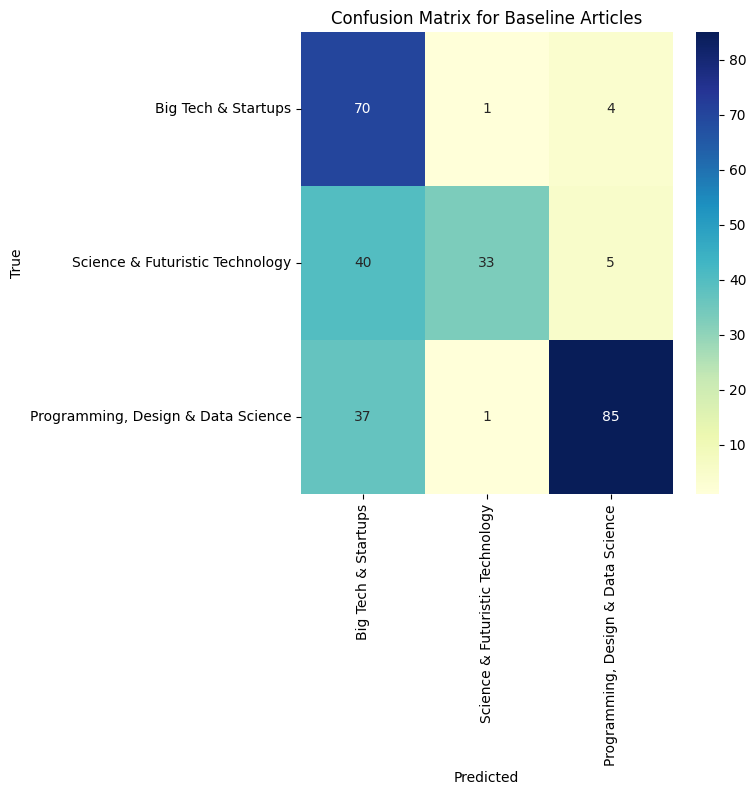

In [64]:
from dummy_predictor import DummyPredictor
dummy_predictor = DummyPredictor()

print("Baseline for articles:")
predictions_dummy_articles = dummy_predictor.evaluate(articles_test_data)
print(classification_report(articles_test_labels, predictions_dummy_articles, target_names=target_names))
plot_confusion_matrix(articles_test_labels, predictions_dummy_articles, target_names, title='Confusion Matrix for Baseline Articles')

## Multinomial NB - articles
The results below are given to us based on the analysis of the articles using Multinomial NB

MultinomialNB for articles:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.89      0.96      0.92        75
   Science & Futuristic Technology       0.99      0.86      0.92        78
Programming, Design & Data Science       0.96      0.99      0.98       123

                          accuracy                           0.95       276
                         macro avg       0.94      0.94      0.94       276
                      weighted avg       0.95      0.95      0.95       276



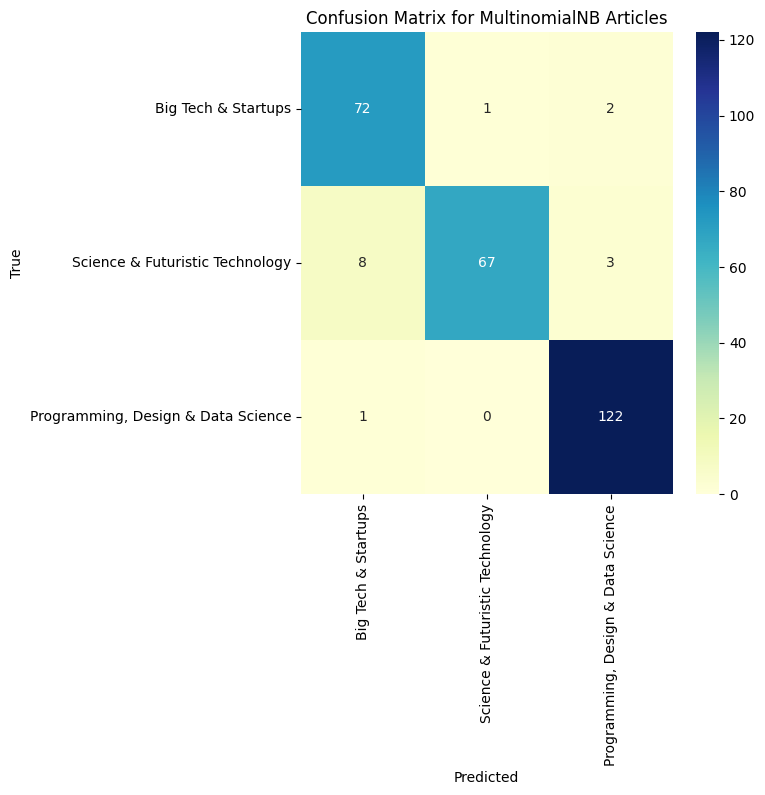

In [65]:
print("MultinomialNB for articles:")
predictions_mnb_articles = train_and_evaluate_multinomial_nb(articles_training_data, articles_training_labels, articles_test_data)
print(classification_report(articles_test_labels, predictions_mnb_articles, target_names=target_names))
plot_confusion_matrix(articles_test_labels, predictions_mnb_articles, target_names, title='Confusion Matrix for MultinomialNB Articles')

## Logistic Regression - articles
The results below are given to us based on the analysis of the articles using Logistic Regression

Logistic Regression for articles:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.89      0.89      0.89        75
   Science & Futuristic Technology       0.93      0.83      0.88        78
Programming, Design & Data Science       0.92      0.98      0.95       123

                          accuracy                           0.92       276
                         macro avg       0.92      0.90      0.91       276
                      weighted avg       0.92      0.92      0.92       276



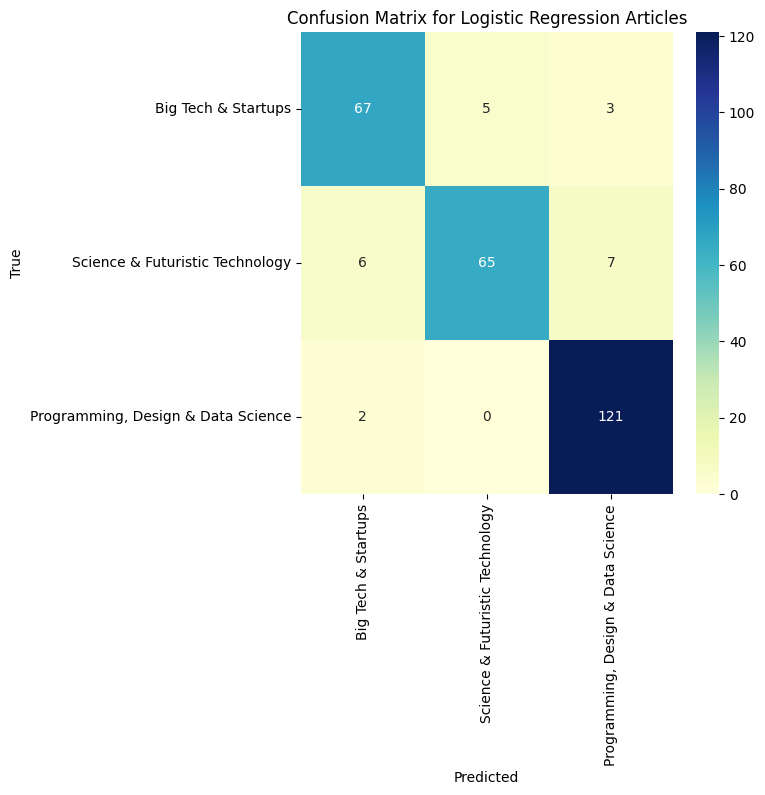

In [66]:
print("Logistic Regression for articles:")
predictions_lr_articles = train_and_evaluate_logistic_regression(articles_training_data, articles_training_labels, articles_test_data)
print(classification_report(articles_test_labels, predictions_lr_articles, target_names=target_names))
plot_confusion_matrix(articles_test_labels, predictions_lr_articles, target_names, title='Confusion Matrix for Logistic Regression Articles')

## TF-IDF Logistic Regression - articles
The results below are given to us based on the analysis of the articles using TF-IDF Logistic Regression

TF-IDF Logistic Regression for articles:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.93      0.91      0.92        75
   Science & Futuristic Technology       0.93      0.85      0.89        78
Programming, Design & Data Science       0.93      1.00      0.96       123

                          accuracy                           0.93       276
                         macro avg       0.93      0.92      0.92       276
                      weighted avg       0.93      0.93      0.93       276



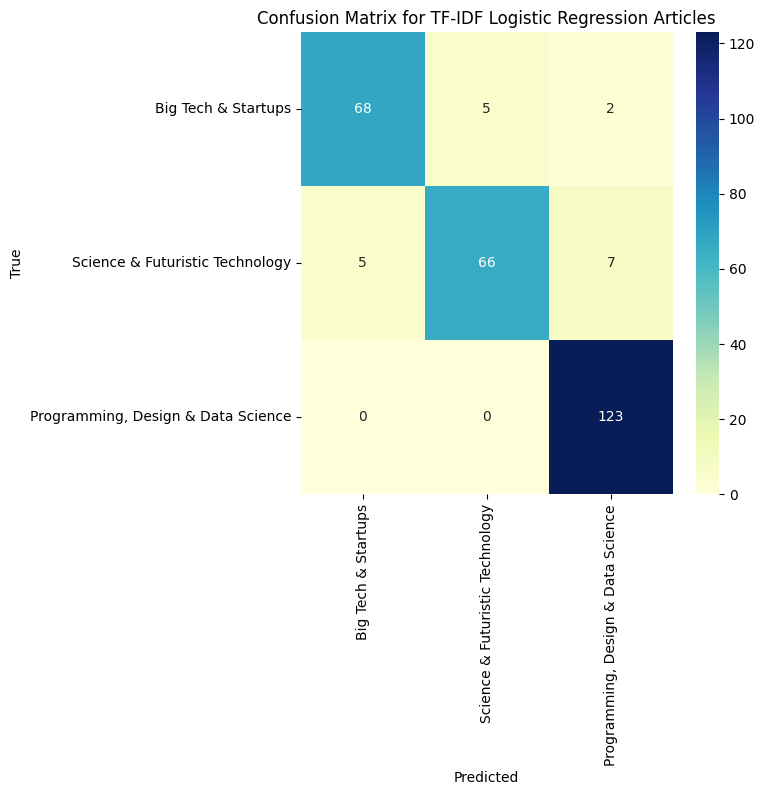

In [67]:
print("TF-IDF Logistic Regression for articles:")
predictions_tfidf_lr_articles = train_and_evaluate_tfidf_logistic_regression(articles_training_data, articles_training_labels, articles_test_data)
print(classification_report(articles_test_labels, predictions_tfidf_lr_articles, target_names=target_names))
plot_confusion_matrix(articles_test_labels, predictions_tfidf_lr_articles, target_names, title='Confusion Matrix for TF-IDF Logistic Regression Articles')

## Bert - articles
The results below are given to us based on the analysis of the articles using the Bert method

Bert for articles:


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/275 [00:00<?, ? examples/s]

Map:   0%|          | 0/275 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.546826,0.818182
2,No log,0.332020,0.890909
3,No log,0.293855,0.901818


                                    precision    recall  f1-score   support

               Big Tech & Startups       0.84      0.95      0.89        75
   Science & Futuristic Technology       0.93      0.82      0.87        77
Programming, Design & Data Science       0.97      0.96      0.96       123

                          accuracy                           0.92       275
                         macro avg       0.91      0.91      0.91       275
                      weighted avg       0.92      0.92      0.92       275



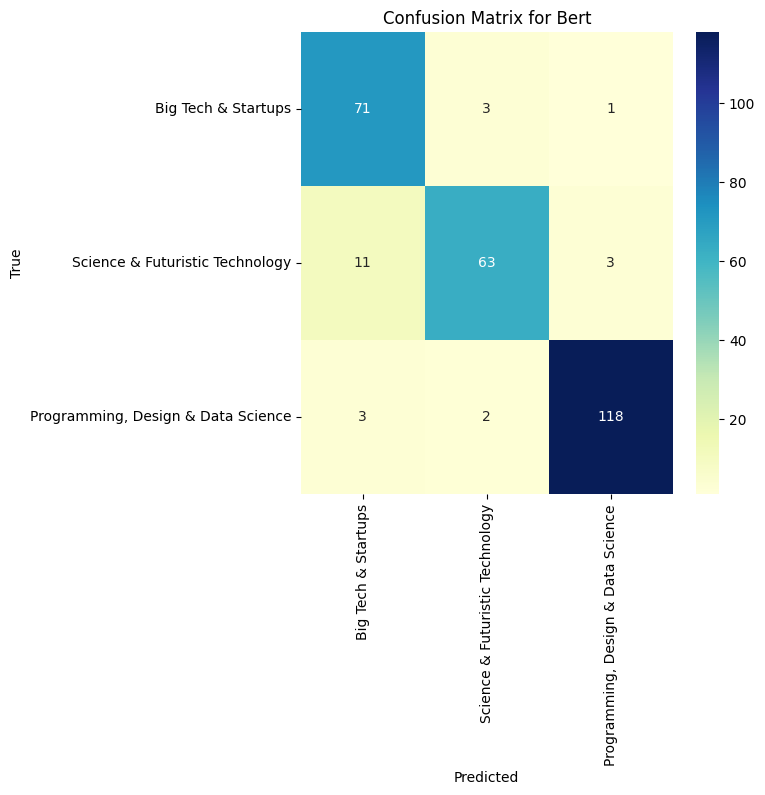

None


In [68]:
print("Bert for articles:")
y_true_art, y_pred_art = train_and_evaluate_bert(articles_train_df, articles_validation_df, articles_test_df)

print(classification_report(y_true_art, y_pred_art, target_names=target_names))
plot_confusion_matrix(y_true_art, y_pred_art, target_names, title='Confusion Matrix for Bert Articles')


## Dummy Predictor - sentences
The results below are given to us based on the analysis of the sentences using the dummy predictor

Baseline for sentences:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.38      0.87      0.53       406
   Science & Futuristic Technology       0.69      0.26      0.38       415
Programming, Design & Data Science       0.83      0.41      0.55       541

                          accuracy                           0.50      1362
                         macro avg       0.63      0.51      0.49      1362
                      weighted avg       0.65      0.50      0.49      1362



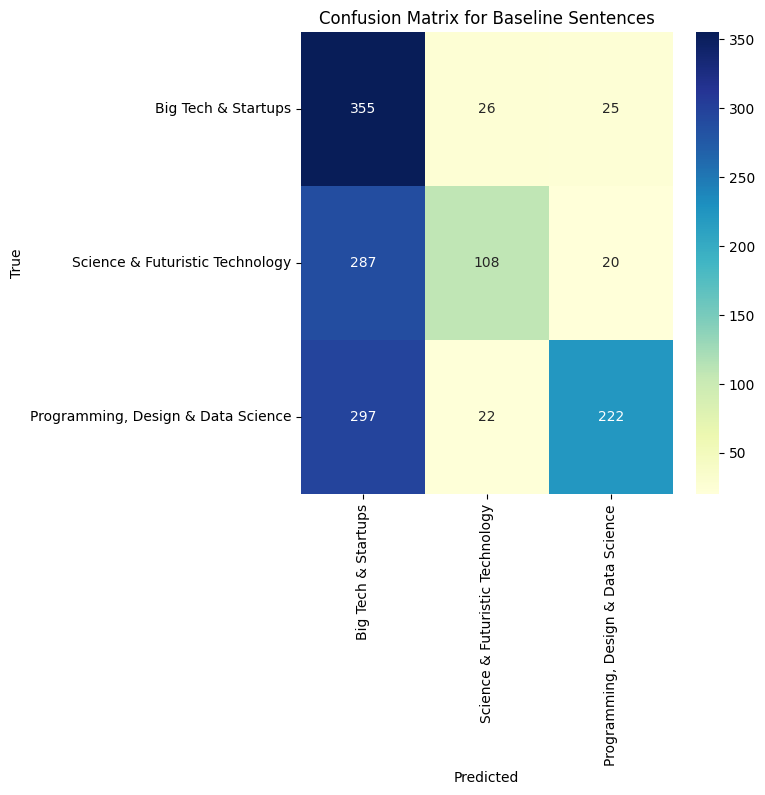

In [69]:
print("Baseline for sentences:")
predictions_dummy_sentences = dummy_predictor.evaluate(sentences_test_data)
print(classification_report(sentences_test_labels, predictions_dummy_sentences, target_names=target_names))
plot_confusion_matrix(sentences_test_labels, predictions_dummy_sentences, target_names, title='Confusion Matrix for Baseline Sentences')

## Multinomial NB - sentences
The results below are given to us based on the analysis of the sentences using Multinomial NB

MultinomialNB for sentences:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.83      0.86      0.85       406
   Science & Futuristic Technology       0.88      0.83      0.86       415
Programming, Design & Data Science       0.90      0.92      0.91       541

                          accuracy                           0.88      1362
                         macro avg       0.87      0.87      0.87      1362
                      weighted avg       0.88      0.88      0.88      1362



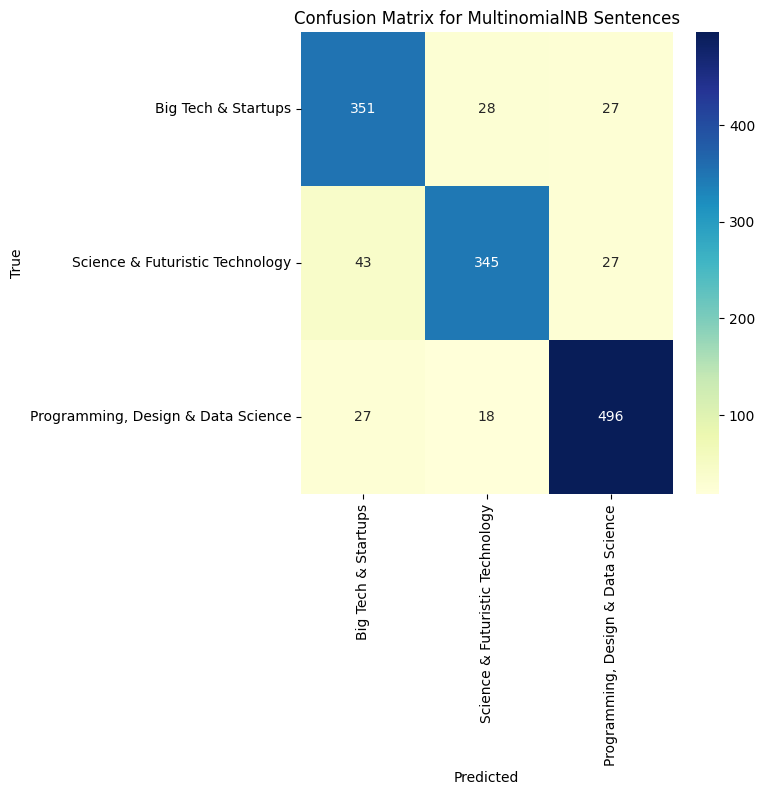

In [70]:
print("MultinomialNB for sentences:")
predictions_mnb_sentences = train_and_evaluate_multinomial_nb(sentences_training_data, sentences_training_labels, sentences_test_data)
print(classification_report(sentences_test_labels, predictions_mnb_sentences, target_names=target_names))
plot_confusion_matrix(sentences_test_labels, predictions_mnb_sentences, target_names, title='Confusion Matrix for MultinomialNB Sentences')

## Logistic Regression - sentences
The results below are given to us based on the analysis of the sentences using Logistic Regression

Logistic Regression for sentences:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.83      0.86      0.85       406
   Science & Futuristic Technology       0.88      0.83      0.86       415
Programming, Design & Data Science       0.90      0.92      0.91       541

                          accuracy                           0.88      1362
                         macro avg       0.87      0.87      0.87      1362
                      weighted avg       0.88      0.88      0.88      1362



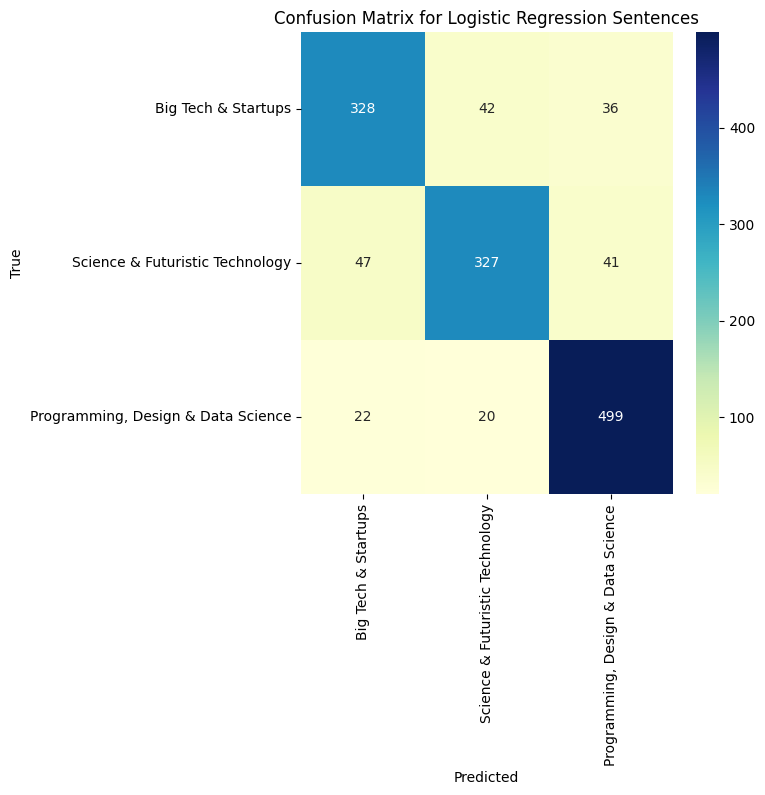

In [71]:
print("Logistic Regression for sentences:")
predictions_lr_sentences = train_and_evaluate_logistic_regression(sentences_training_data, sentences_training_labels, sentences_test_data)
print(classification_report(sentences_test_labels, predictions_mnb_sentences, target_names=target_names))
plot_confusion_matrix(sentences_test_labels, predictions_lr_sentences, target_names, title='Confusion Matrix for Logistic Regression Sentences')

## TF-IDF Logistic Regression - sentences
The results below are given to us based on the analysis of the sentences using TF-IDF Logistic Regression

TF-IDF Logistic Regression for sentences:
                                    precision    recall  f1-score   support

               Big Tech & Startups       0.85      0.79      0.82       406
   Science & Futuristic Technology       0.85      0.84      0.84       415
Programming, Design & Data Science       0.87      0.92      0.89       541

                          accuracy                           0.86      1362
                         macro avg       0.86      0.85      0.85      1362
                      weighted avg       0.86      0.86      0.86      1362



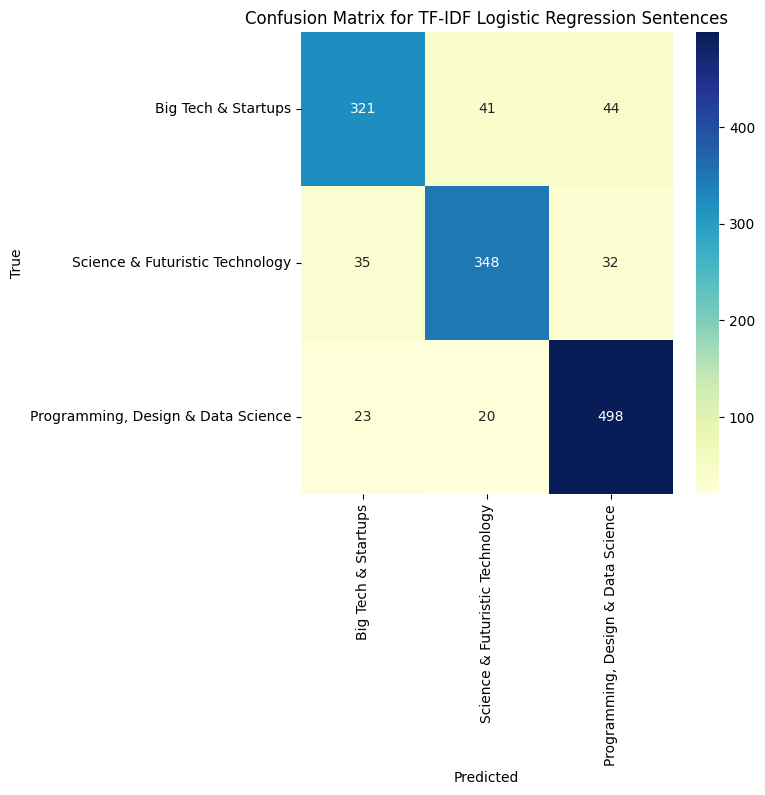

In [72]:
print("TF-IDF Logistic Regression for sentences:")
predictions_tfidf_lr_sentences = train_and_evaluate_tfidf_logistic_regression(sentences_training_data, sentences_training_labels, sentences_test_data)
print(classification_report(sentences_test_labels, predictions_tfidf_lr_sentences, target_names=target_names))
plot_confusion_matrix(sentences_test_labels, predictions_tfidf_lr_sentences, target_names, title='Confusion Matrix for TF-IDF Logistic Regression Sentences')

## Bert - sentences
The results below are given to us based on the analysis of the sentences using the Bert method

Bert for sentences:


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/275 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.782170,0.703333
2,No log,0.548378,0.800000
3,No log,0.497528,0.813333


                                    precision    recall  f1-score   support

               Big Tech & Startups       0.70      0.86      0.78        80
   Science & Futuristic Technology       0.89      0.82      0.86        80
Programming, Design & Data Science       0.90      0.81      0.85       115

                          accuracy                           0.83       275
                         macro avg       0.83      0.83      0.83       275
                      weighted avg       0.84      0.83      0.83       275



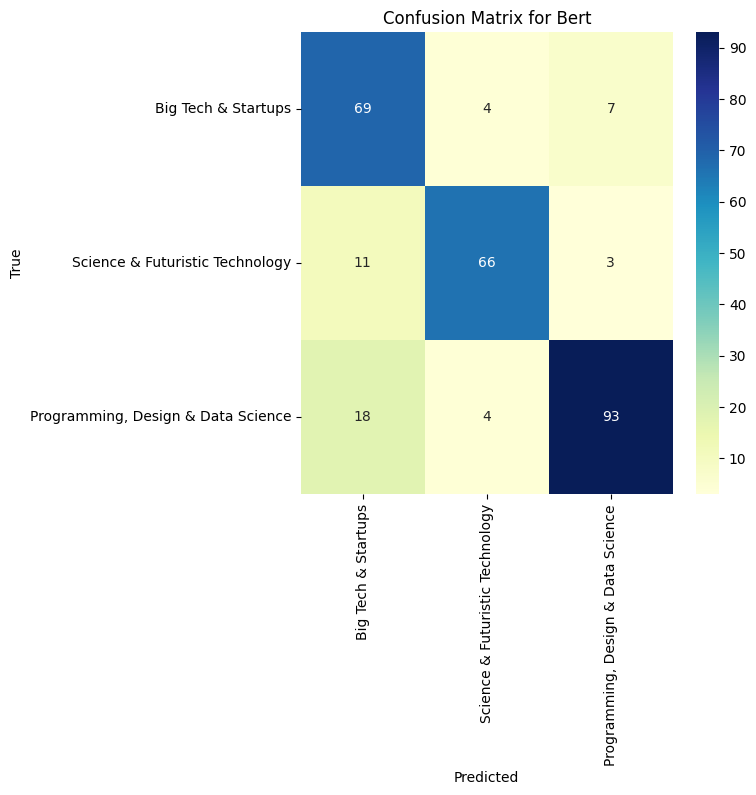

None


In [73]:
print("Bert for sentences:")
y_true_sent, y_pred_sent = train_and_evaluate_bert(sentences_train_df, sentences_validation_df, sentences_test_df)

print(classification_report(y_true_sent, y_pred_sent, target_names=target_names))
plot_confusion_matrix(y_true_sent, y_pred_sent, target_names, title='Confusion Matrix for Bert Sentences')

## Comparing all results


In order to have a better view of each method use, below you will find a table so we can have a side by side of the classification results.

In [74]:
def plot_performance_metrics(reports, model_names):
    metrics = ['precision', 'recall', 'f1-score']
    data = []

    for report in reports:
        scores = report['macro avg']
        data.append([scores[metric] for metric in metrics])

    df = pd.DataFrame(data, columns=metrics, index=model_names)
    df.plot(kind='bar', figsize=(10, 6))
    plt.title('Performance Metrics Comparison')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.legend(loc='upper left')

    # Adjust y-axis limits
    plt.ylim(0.3, 1)

    plt.show()

In [75]:
report_dummy_articles = classification_report(articles_test_labels, predictions_dummy_articles, output_dict=True)
report_mnb_articles = classification_report(articles_test_labels, predictions_mnb_articles, output_dict=True)
report_lr_articles = classification_report(articles_test_labels, predictions_lr_articles, output_dict=True)
report_tfidf_lr_articles = classification_report(articles_test_labels, predictions_tfidf_lr_articles, output_dict=True)
report_bert_articles =classification_report(y_true_art, y_pred_art, output_dict=True)

report_dummy_sentences = classification_report(sentences_test_labels, predictions_dummy_sentences, output_dict=True)
report_mnb_sentences = classification_report(sentences_test_labels, predictions_mnb_sentences, output_dict=True)
report_lr_sentences = classification_report(sentences_test_labels, predictions_lr_sentences, output_dict=True)
report_tfidf_lr_sentences = classification_report(sentences_test_labels, predictions_tfidf_lr_sentences, output_dict=True)
report_bert_sentences = classification_report(y_true_sent, y_pred_sent, output_dict=True)

articles_reports = [
    report_dummy_articles,
    report_mnb_articles,
    report_lr_articles,
    report_tfidf_lr_articles,
    report_bert_articles
]

sentences_reports = [
    report_dummy_sentences,
    report_mnb_sentences,
    report_lr_sentences,
    report_tfidf_lr_sentences,
    report_bert_sentences
]

model_names = [
    'Baseline',
    'MultinomialNB',
    'Logistic Regression',
    'TF-IDF Logistic Regression',
    'Bert'
]

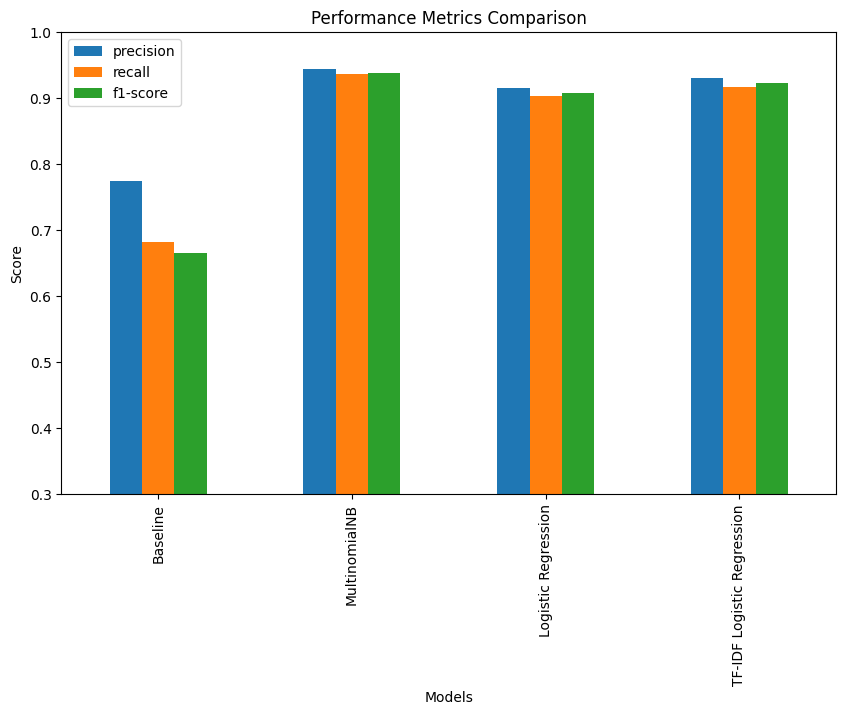

In [76]:
plot_performance_metrics(articles_reports, model_names)

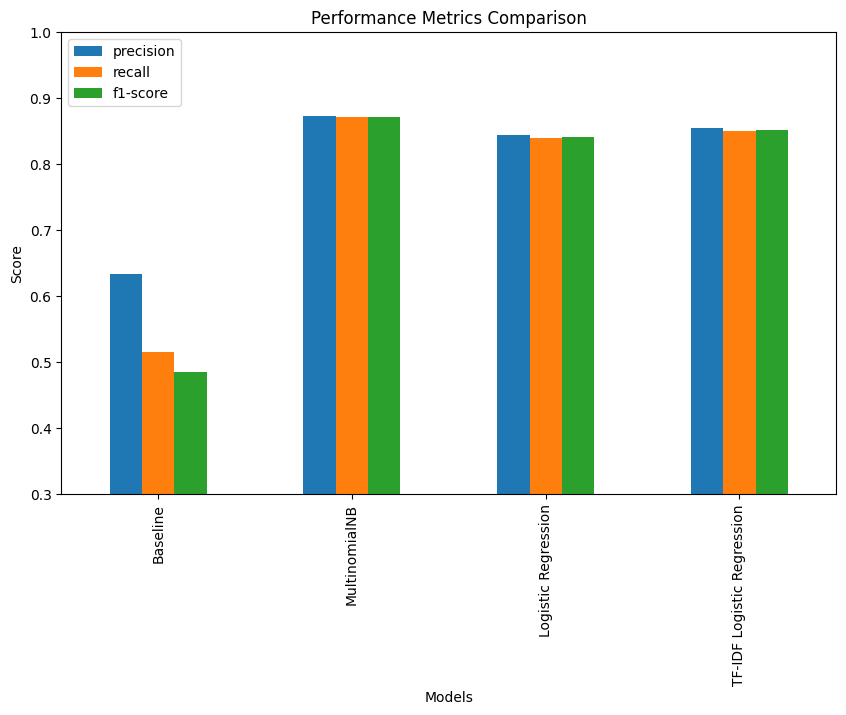

In [77]:
plot_performance_metrics(sentences_reports, model_names)